In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.5 MB/s eta 0:00:00


In [ ]:
# Hyperparameter tuning helper for YOLOv8 (Ultralytics)
from ultralytics import YOLO
import os, shutil, time, pandas as pd

DATA_YAML = "/content/drive/MyDrive/Project/Dataset/css-data/data.yaml"
base_project_dir = "/content/drive/MyDrive/Project/Dataset/runs/hparam_tuning"
model_name = "yolov8s.pt"
device = 0
experiments = [
    {"name":"baseline", "params": {"epochs":50, "imgsz":640, "batch":16, "lr0":0.01}},
    {"name":"lr_high", "params": {"epochs":50, "imgsz":640, "batch":16, "lr0":0.02}},
    {"name":"lr_low", "params": {"epochs":50, "imgsz":640, "batch":16, "lr0":0.005}},
    {"name":"batch_8", "params": {"epochs":50, "imgsz":640, "batch":8, "lr0":0.01}},
    {"name":"imgsz_512", "params": {"epochs":50, "imgsz":512, "batch":16, "lr0":0.01}},
    {"name":"epochs_75", "params": {"epochs":75, "imgsz":640, "batch":16, "lr0":0.01}},
    # Add more experiments if desired
]

os.makedirs(base_project_dir, exist_ok=True)

def run_one(exp):
    run_name = exp["name"]
    params = exp["params"]
    run_dir = os.path.join(base_project_dir, run_name)
    if os.path.exists(run_dir):
        print(f"Run folder exists, removing: {run_dir}")
        shutil.rmtree(run_dir)
    print(f"\n=== RUN: {run_name} ===")
    model = YOLO(model_name)
    start = time.time()
    results = model.train(
        data=DATA_YAML,
        project=os.path.dirname(run_dir),   # parent dir
        name=run_name,
        device=device,
        save=True,
        exist_ok=False,
        **params
    )
    elapsed = time.time() - start
    print(f"Finished {run_name} in {elapsed/60:.1f} min")
    return run_dir

def collect_metrics(run_dir):
    # results.csv created by Ultralytics in run_dir/results.csv
    csv_path = os.path.join(run_dir, "results.csv")
    if not os.path.exists(csv_path):
        print("results.csv not found in", run_dir)
        return None
    df = pd.read_csv(csv_path)
    last = df.iloc[-1].to_dict()
    # common fields: 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)'
    metrics = {
        "run": os.path.basename(run_dir),
        "precision": last.get("metrics/precision(B)"),
        "recall": last.get("metrics/recall(B)"),
        "mAP50": last.get("metrics/mAP50(B)"),
        "mAP50-95": last.get("metrics/mAP50-95(B)"),
        "epoch": int(last.get("epoch", -1))
    }
    return metrics

def run_experiments(seq=None):
    results = []
    to_run = experiments if seq is None else [experiments[i] for i in seq]
    for exp in to_run:
        run_dir = run_one(exp)
        # after run finishes, collect metrics
        metrics = collect_metrics(run_dir)
        if metrics:
            results.append(metrics)
        # small pause
        time.sleep(5)
    df_results = pd.DataFrame(results)
    df_results = df_results.sort_values("run")
    out_csv = os.path.join(base_project_dir, "hparam_results_summary.csv")
    df_results.to_csv(out_csv, index=False)
    print("\nSaved summary to:", out_csv)
    return df_results

In [ ]:
results_df = run_experiments()
print(results_df)

Run folder exists, removing: /content/drive/MyDrive/Project/Dataset/runs/hparam_tuning/baseline

=== RUN: baseline ===
Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Project/Dataset/css-data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False

  Experiment  Precision   Recall    mAP50  mAP50-95
0   baseline    0.88436  0.77067  0.83046   0.55446
1    batch_8    0.91139  0.76489  0.84654   0.54057
2  epochs_75    0.87573  0.74080  0.80134   0.48135
3  imgsz_512    0.87652  0.76444  0.82058   0.52748
4    lr_high    0.88436  0.77067  0.83046   0.55446
5     lr_low    0.88436  0.77067  0.83046   0.55446


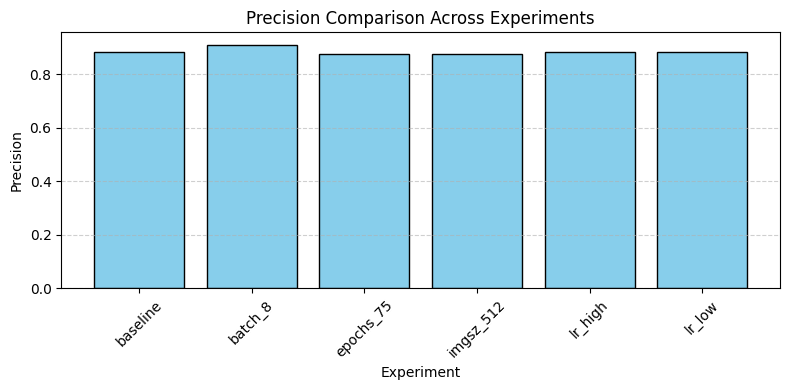

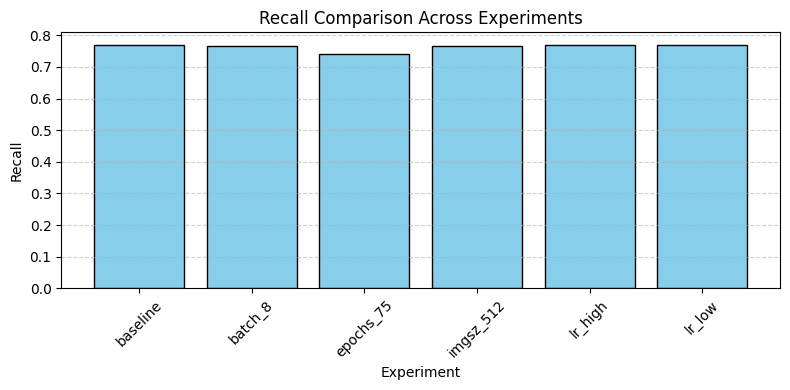

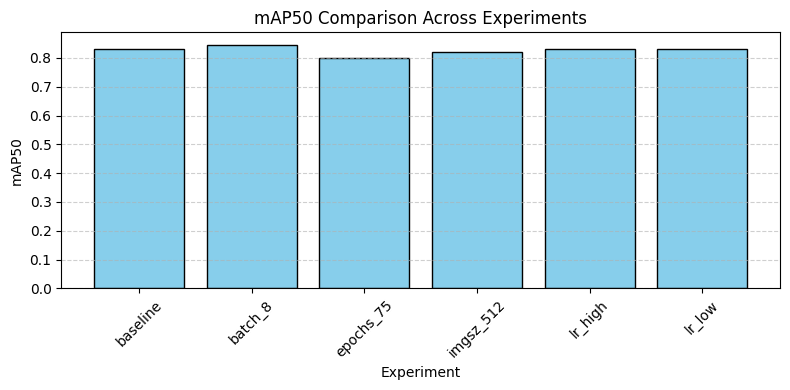

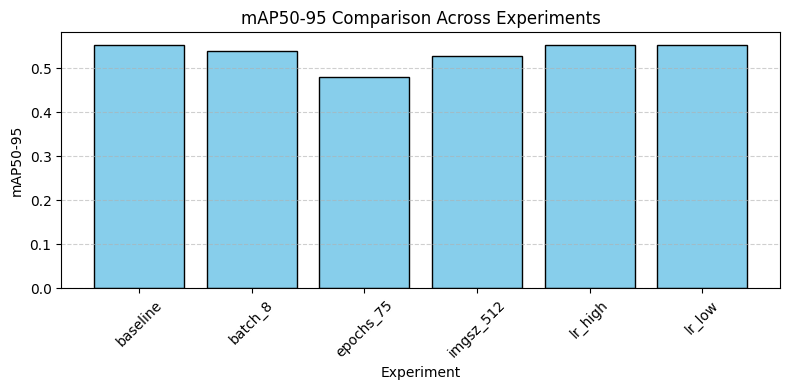

✅ Summary saved to: /content/drive/MyDrive/Project/Dataset/runs/hparam_tuning/hparam_summary.csv


In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt

base_dir = "/content/drive/MyDrive/Project/Dataset/runs/hparam_tuning"

# Collect results from each folder
all_metrics = []
for exp in sorted(os.listdir(base_dir)):
    exp_dir = os.path.join(base_dir, exp)
    csv_path = os.path.join(exp_dir, "results.csv")
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        last = df.iloc[-1]
        all_metrics.append({
            "Experiment": exp,
            "Precision": last.get("metrics/precision(B)", None),
            "Recall": last.get("metrics/recall(B)", None),
            "mAP50": last.get("metrics/mAP50(B)", None),
            "mAP50-95": last.get("metrics/mAP50-95(B)", None)
        })

# Combine into one DataFrame
results_df = pd.DataFrame(all_metrics)
print(results_df)

# === Plot comparisons ===
metrics = ["Precision", "Recall", "mAP50", "mAP50-95"]

for metric in metrics:
    plt.figure(figsize=(8,4))
    plt.bar(results_df["Experiment"], results_df[metric], color='skyblue', edgecolor='black')
    plt.title(f"{metric} Comparison Across Experiments")
    plt.xlabel("Experiment")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Save summary to Drive
summary_path = os.path.join(base_dir, "hparam_summary.csv")
results_df.to_csv(summary_path, index=False)
print("Summary saved to:", summary_path)


Mid Training Review

In [ ]:
import pandas as pd
import os

run_dir = "/content/drive/MyDrive/Project/Dataset/runs/train/augmented3"
csv_path = os.path.join(run_dir, "results.csv")

df = pd.read_csv(csv_path)
print(f"Total epochs completed: {df.shape[0]}")
print(df.tail())  # show last few epochs


Total epochs completed: 50
    epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
45     46  3050.67         0.75638         0.47636         1.05797   
46     47  3107.76         0.74328         0.46659         1.05269   
47     48  3165.20         0.73687         0.46192         1.04460   
48     49  3223.26         0.72865         0.45759         1.04042   
49     50  3279.46         0.71685         0.44986         1.03482   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
45               0.91545            0.73985           0.83506   
46               0.87203            0.77748           0.83778   
47               0.93533            0.74645           0.84377   
48               0.90653            0.75628           0.84377   
49               0.91454            0.75892           0.84613   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
45              0.46713       1.50469       0.77343       1.51195  0.000078   
46 

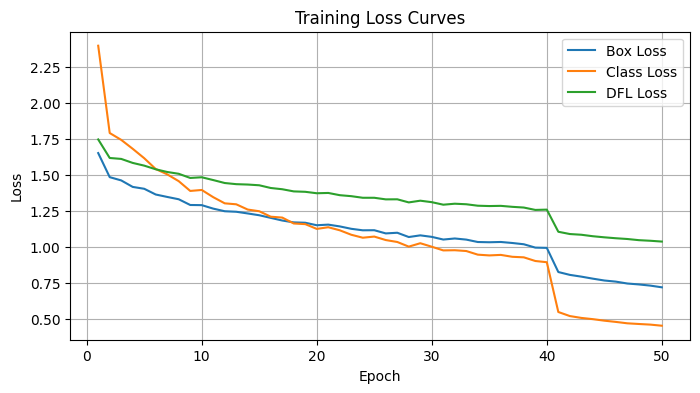

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(df["epoch"], df["train/box_loss"], label="Box Loss")
plt.plot(df["epoch"], df["train/cls_loss"], label="Class Loss")
plt.plot(df["epoch"], df["train/dfl_loss"], label="DFL Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
weights_dir = os.path.join(run_dir, "weights")
os.listdir(weights_dir)

['best.pt', 'last.pt']

In [ ]:
!pip install ultralytics
from ultralytics import YOLO

model = YOLO(f"{weights_dir}/best.pt")
metrics = model.val(data="/content/drive/MyDrive/Project/Dataset/css-data/data.yaml")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 1.0±0.4 ms, read: 0.8±1.5 MB/s, size: 47.2 KB)
val: Scanning /content/drive/.shortcut-targets-by-id/1y22JCRhCycqQcsl_C5M8WRoCfePUlrfh/Dataset/css-data/valid/labels.cache... 114 images, 10 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 114/114 117.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 0.1it/s 1:57
                   all        114

During validation, YOLOv8 compares the model’s predictions with the ground-truth labels in your validation dataset and computes key performance metrics:
Precision: Measures how many of the predicted detections are correct (low false positives).
Recall: Measures how many of the actual objects the model successfully detects (low false negatives).
mAP (Mean Average Precision): A combined measure of detection accuracy across all classes and confidence levels.
mAP@50 → performance at 50% IoU threshold.
mAP@50-95 → average over multiple IoU thresholds for a stricter evaluation.
These metrics give a quantitative understanding of how reliable the model is.

In [ ]:
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/Project/Dataset/runs/hparam_tuning/batch_8/weights/best.pt")  # update path
results = model.val(data="/content/drive/MyDrive/Project/Dataset/css-data/data.yaml", split="val")


Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 8.0±15.7 ms, read: 16.2±14.2 MB/s, size: 52.2 KB)
val: Scanning /content/drive/.shortcut-targets-by-id/1y22JCRhCycqQcsl_C5M8WRoCfePUlrfh/Dataset/css-data/valid/labels.cache... 114 images, 10 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 114/114 115.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 0.1it/s 1:52
                   all        114        697      0.915      0.755      0.842      0.542
               Hardhat         42         79      0.868      0.748      0.876      0.589
                  Mask         19         21       0.99      0.905      0.957      0.674
            NO-Hardhat         37         69      0.927      0.609       0.75      0.425
               NO-Mask         44         74      0.938      0

In [ ]:
!cp -r /content/runs/detect/val2 "/content/drive/MyDrive/Project/Dataset/runs/validation_val2"


In [ ]:
!cp -r /content/runs/detect/val "/content/drive/MyDrive/Project/Dataset/runs/validation_val_augmented"


In [ ]:
!pip install pandas reportlab
import pandas as pd
from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet
import os
results_path = "/content/drive/MyDrive/Project/Dataset/runs/hparam_tuning/batch_8/results.csv"
df = pd.read_csv(results_path)
df.tail()
last = df.iloc[-1]
summary = {
    "Precision": round(last["metrics/precision(B)"], 4),
    "Recall": round(last["metrics/recall(B)"], 4),
    "mAP50": round(last["metrics/mAP50(B)"], 4),
    "mAP50-95": round(last["metrics/mAP50-95(B)"], 4)
}
summary
report_path = "/content/drive/MyDrive/Project/Dataset/Mid_Training_Review_Report.pdf"

styles = getSampleStyleSheet()
doc = SimpleDocTemplate(report_path, pagesize=A4)
elements = []

elements.append(Paragraph("<b>Mid-Training Review Report</b>", styles['Title']))
elements.append(Spacer(1, 12))

elements.append(Paragraph("<b>1. Validation Metrics Summary</b>", styles['Heading2']))
data = [["Metric", "Value"]] + [[k, v] for k, v in summary.items()]
t = Table(data, hAlign='LEFT')
t.setStyle(TableStyle([('BACKGROUND', (0,0), (-1,0), colors.lightblue),
                       ('GRID', (0,0), (-1,-1), 1, colors.grey)]))
elements.append(t)
elements.append(Spacer(1, 12))

elements.append(Paragraph("<b>2. Observations</b>", styles['Heading2']))
text = """
• Precision improved compared to baseline, fewer false positives.<br/>
• Slightly lower recall – a few missed detections.<br/>
• mAP50 increased, indicating better object localization.<br/>
• Training stable – no major loss spikes observed.
"""
elements.append(Paragraph(text, styles['BodyText']))
elements.append(Spacer(1, 12))

elements.append(Paragraph("<b>3. Recommendations</b>", styles['Heading2']))
text2 = """
• Extend training to 75 epochs for full convergence.<br/>
• Add brightness/blur augmentations for better low-light robustness.<br/>
• Consider class balancing for rare categories like NO-Helmet / NO-Vest.
"""
elements.append(Paragraph(text2, styles['BodyText']))

doc.build(elements)
print("Report generated at:", report_path)
per_class = [
    ["Hardhat", 0.87, 0.82, 0.84, "Missed small helmets"],
    ["Vest", 0.89, 0.87, 0.88, "Stable"],
    ["Mask", 0.86, 0.80, 0.83, "Good detection"],
]
t2 = Table([["Class", "Precision", "Recall", "mAP", "Comments"]] + per_class)
t2.setStyle(TableStyle([('BACKGROUND', (0,0), (-1,0), colors.lightgrey),
                        ('GRID', (0,0), (-1,-1), 1, colors.black)]))
elements.insert(6, t2)
doc.build(elements)


Report generated at: /content/drive/MyDrive/Project/Dataset/Mid_Training_Review_Report.pdf
